# GEOtiled Demo: A Scalable Workflow for Generating Large Datasets of High-Resolution Terrain Parameters

The GEOtiled workflow is comprised of three stages: 
1. Reproject and partition a Digital Elevation Model (DEM) into tiles, each with a buffer region
2. Compute the terrain parameters for each individual tile concurrently
3. Mosaic each parameter's tiles together

<p style="text-align:center">
    <img src="demo_images/geotiled_workflow.png" width="800"/>
</p>
<p style="text-align:center">
    <b>Figure 1. </b>GEOtiled Workflow
</p>
    
Terrain parameters are computed using DEMs from [USGS 3DEP Products](https://www.usgs.gov/3d-elevation-program/about-3dep-products-services) to compute 3 topographic parameters: aspect, hillshade, and slope. By default, this demo uses 3DEP products covering the entirety of the US state of Tennessee at a 30m resolution.

If you would like to work with a different region of data, go to the [USGS Data Download Application](https://apps.nationalmap.gov/downloader/#/elevation) and use the map to look for available DEM data. Data should be downloaded using the TXT button located under the *Products* tab, and the text file should be stored in your working directory.

**IMPORTANT NOTE: Larger regions or higher resolutions will significantly increase the size of the data and the time to compute it.** 

## Environment Setup

The first cell below imports required libraries to run the notebook.

In [1]:
# DO NOT MODIFY: Import library used to run notebook
import geotiled

### Settings

In the following cell you may specify variables such as what data to download, the number of intermediary tiles to use for computation, and the file path where data will be stored. Comments for what each variable is for is included.

**Important Notes**
* For DEM download, three different methods are available: from a text file with a list of USGS download links, based off a shape file, or a specified latitude and longitude box
  * A text file from the USGS page should be stored in the working directory or child directory
  * Shape files are available for all US states and Washington DC. For the shapefile variable, specify the state abbreviation to use the correlating shapefile (e.g. TN for Tennessee)
  * A bounding box can be specified using the following syntax: {"xmin": val,"ymin": val,"xmax": val,"ymax": val}. X values correlate to longitude and Y values correlate to latitude

In [2]:
# Data download variables
download_list = 'urls.txt'
dataset = '30m'
region = 'TN'

# Crop variables
tile_dimensions = [9137,4216] # Tile dimensions are width x height (in pixels)

# Compute variables
parameters = ['slope','aspect','hillshade'] # Parameters to compute
method = 'SAGA' # Library to use algorithms from
processes = 8 # Number of concurrent processes

# Update and set working directory
working_directory = '/media/volume/geotiled-saga/tn_30m'
geotiled.set_working_directory(working_directory)

## Pre-processing of the DEM

### Fetch Data

`fetch_dem()` pulls DEM data directly from the USGS webpage with a specified shape file or bounding box and a desired dataset. It will return a text file with the download URLs which can be saved or immediately downloaded from. **Note that if both a shape file and bounding box are given, the shape file will take precedent.**

`download_files()` downloads the DEMs from a supplied text file with URLs or a Python list of strings containing the URLs. If you would like to use your own text file to download DEMs, skip `fetch_dem()` and only run this function.

In [3]:
# Create a text file with download URLs from a shape file
geotiled.fetch_dem(shapefile=region, txt_file=download_list, dataset=dataset)

# Download files from the created text file
geotiled.download_files(download_list=download_list, download_folder='dem_tiles')



ownloading: 100%|█████████████████████████████████████████████| 1.72G/1.72G [01:24<00:00, 20.4MB/s]

### Mosaic and Reproject DEMs

`build_mosaic()` creates a mosaic from a list of GeoTIFF files.

`reproject()` reprojects a specified GeoTIFF raster dataset from its original coordinate system to a new specified projection. DEMs from USGS are projected using the Global Coordinate System (GCS) by default.

In [4]:
# Build mosaic from DEMs
geotiled.build_mosaic(input_folder='dem_tiles', output_file='mosaic.tif', description='Elevation', cleanup=False)

# Reproject the mosaic to Projected Coordinate System (PCS) EPSG:26918 - NAD83 UTM Zone 18N
geotiled.reproject(input_file='mosaic.tif', output_file='elevation.tif', projection='EPSG:26918', cleanup=False)

## Compute Parameters with GEOtiled

`crop_and_compute()` concurrently crops the original file into tiles, computes desired terrain parameters, and crops off the buffer region of all computed parameters for a provided file containing elevation data.

`build_mosaic_buffer()` is similar to `build_mosaic()` but includes extra logic to handle averaging of buffer regions made from cropping the mosaic.

In [5]:
# Run GEOtiled to crop and compute all terrain parameters for the given elevation data
geotiled.crop_and_compute(input_file='elevation.tif', column_length=tile_dimensions[0], row_length=tile_dimensions[1], parameter_list=parameters, compute_method=method, num_processes=processes)

In [6]:
# Build mosaics for each of the computed parameter tiles
geotiled.build_mosaic(input_folder='unbuffered_slope_tiles', output_file='slope.tif', cleanup=False)
geotiled.build_mosaic(input_folder='unbuffered_aspect_tiles', output_file='aspect.tif', cleanup=False)
geotiled.build_mosaic(input_folder='unbuffered_hillshade_tiles', output_file='hillshade.tif', cleanup=False)

## Visualize the Results

`generate_img()` plots the GeoTIFF data. A wide variety of parameters are available for this function, and details on what each one does can be found in the function documentation.

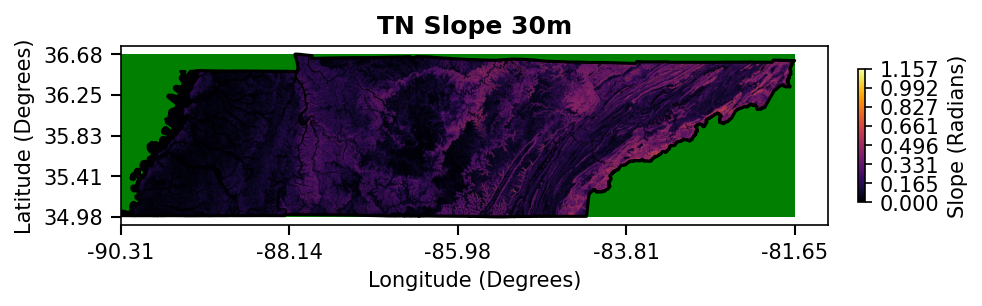

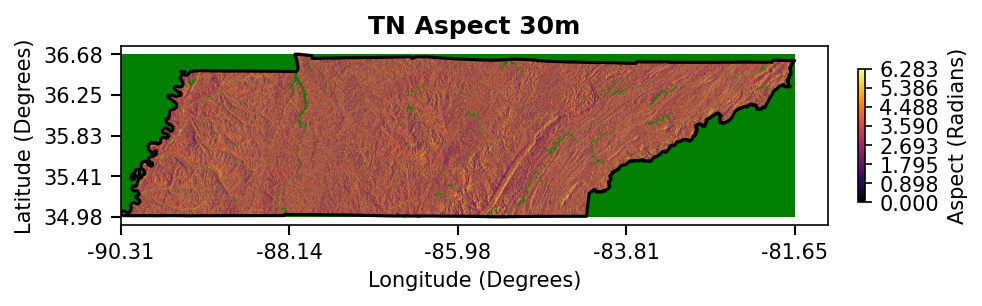

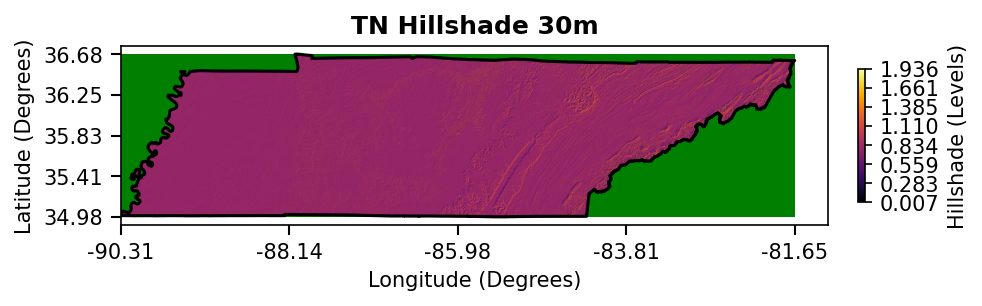

In [7]:
# Visualize the parameters
slp_img = geotiled.generate_img(tif='slope.tif', downsample=5, shp_files=region, crop_shp=True, reproject_gcs=True, title="TN Slope 30m", zunit="Radian", xyunit="Degree", ztype="Slope")
asp_img = geotiled.generate_img(tif='aspect.tif', downsample=5, shp_files=region, crop_shp=True, reproject_gcs=True, title="TN Aspect 30m", zunit="Radian", xyunit="Degree", ztype="Aspect")
hld_img = geotiled.generate_img(tif='hillshade.tif', downsample=5, shp_files=region, crop_shp=True, reproject_gcs=True, title="TN Hillshade 30m", zunit="Level", xyunit="Degree", ztype="Hillshade")

## End of Demo